# Тематическое моделирование с помощью латентного размещения Дирихле

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import spacy

from gensim import models, corpora
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

## Датасет

Будем использовать корпус из 90 000 CNN новостей, созданный для вопросно-ответных моделей. Немного предобработанную версию можно найти на Google Drive. В этой версии удалены некоторые метаданные.

In [2]:
!gdown -c 'https://drive.google.com/uc?id=1Ho5XKQmxHWNLuZu8FYGR4KFS28_lcfGY'

Skipping already downloaded file cnn_articles.txt


Этот корпус - большей текстовый файл, в котором каждая статья разделена строкой *@delimiter*.

Разделим статьи.

In [3]:
with open("cnn_articles.txt", "r", encoding="utf8") as f:
    articles = f.read().split("@delimiter")

In [4]:
print(len(articles))
print(articles[0])

92579
 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affairs program for children -- several youngsters in Kabul, Afghanistan, say they are afraid of daily violence and the frequent explosions in their war-torn country.

In response, Sedwill says: "Here in Kabul, and other big cities actually, there are very few of these bombs. The children are probably safer here than they would be in London, New York or Glasgow or many other cities.

"Most children can go about their lives in safety. It's a very family-oriented society. So it is a little bit like a city of villages," he added.

A U.N. report released earlier this year seems to contradict Sedwill's assessment.

The February report, by the special representative for children and armed confli

Оставим только 20 000 статьей

In [5]:
DATASET_SIZE = 20000
dataset = articles[:DATASET_SIZE]

## Токенизация

Для начала воспользуемся обычным токенизатором `spacy`.

Оставим только слова.

In [6]:
nlp = spacy.blank("en")


def basic_filter(doc: spacy.tokens.Doc):
    return [t.text for t in doc if t.is_alpha]

In [7]:
tokenized_articles = [
    basic_filter(doc)
    for doc in nlp.pipe(dataset, batch_size=1024, n_process=-1)
]

## Словарь

Создадим словарь, позволяющий получать *индекс по слову*.

In [8]:
dictionary = corpora.Dictionary(tokenized_articles)

sample_token = "news"
print(
    f"Индекс для токена '{sample_token}': {dictionary.token2id[sample_token]}"
)

Индекс для токена 'news': 1039


## Частоты слов

Теперь можно посчитать частоты слов в каждом документе

In [9]:
corpus_bow = [dictionary.doc2bow(article) for article in tokenized_articles]

## Модель

Выберем количество тем равной 20.

Создадим простую LDA модель.

In [10]:
NUM_TOPICS = 20

In [11]:
lda_model = models.LdaModel(
    corpus=corpus_bow,
    num_topics=NUM_TOPICS,
    id2word=dictionary,
    random_state=1,
)

In [12]:
lda_model.print_topics()

[(0,
  '0.068*"the" + 0.041*"of" + 0.027*"and" + 0.025*"to" + 0.025*"in" + 0.023*"a" + 0.013*"is" + 0.009*"for" + 0.008*"that" + 0.008*"The"'),
 (1,
  '0.046*"the" + 0.031*"I" + 0.030*"a" + 0.028*"to" + 0.022*"and" + 0.019*"in" + 0.017*"of" + 0.012*"was" + 0.012*"it" + 0.012*"that"'),
 (2,
  '0.064*"the" + 0.030*"of" + 0.025*"to" + 0.023*"and" + 0.020*"in" + 0.017*"a" + 0.011*"that" + 0.011*"is" + 0.009*"Syria" + 0.008*"for"'),
 (3,
  '0.038*"the" + 0.032*"to" + 0.029*"and" + 0.029*"of" + 0.024*"a" + 0.017*"that" + 0.016*"in" + 0.013*"is" + 0.010*"are" + 0.009*"for"'),
 (4,
  '0.069*"the" + 0.030*"of" + 0.029*"to" + 0.024*"and" + 0.021*"in" + 0.019*"a" + 0.015*"said" + 0.011*"The" + 0.010*"that" + 0.009*"on"'),
 (5,
  '0.060*"the" + 0.031*"in" + 0.029*"of" + 0.028*"to" + 0.027*"and" + 0.021*"a" + 0.014*"said" + 0.011*"that" + 0.011*"The" + 0.008*"is"'),
 (6,
  '0.054*"the" + 0.033*"to" + 0.030*"of" + 0.027*"in" + 0.026*"and" + 0.025*"a" + 0.012*"said" + 0.011*"that" + 0.009*"The" + 0.0

## Улучшение предобработки текстов

- Удалим стоп слова, используя список стоп слов `spacy`.
- Оставим только **существительные (nouns)**, **глаголы (verbs)** и **прилагательные (adjectives)**.
- Возьмем лемму токена.

In [13]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tok2vec"])


def improved_filter(doc: spacy.tokens.Doc):
    return [
        t.lemma_
        for t in doc
        if t.is_alpha and not t.is_stop and t.pos_ in ["NOUN", "VERB", "ADJ"]
    ]

In [14]:
tokenized_articles_w_pos = [
    improved_filter(doc)
    for doc in nlp.pipe(dataset, batch_size=1024, n_process=-1)
]


In [15]:
dictionary_w_pos = corpora.Dictionary(tokenized_articles_w_pos)

In [16]:
corpus_bow_w_pos = [
    dictionary_w_pos.doc2bow(article) for article in tokenized_articles_w_pos
]

In [17]:
lda_model = models.LdaModel(
    corpus=corpus_bow_w_pos,
    num_topics=NUM_TOPICS,
    id2word=dictionary_w_pos,
    random_state=1,
)

In [18]:
lda_model.print_topics()

[(0,
  '0.029*"russia" + 0.024*"russian" + 0.021*"ukraine" + 0.014*"said" + 0.011*"putin" + 0.009*"ukrainian" + 0.008*"moscow" + 0.008*"european" + 0.007*"french" + 0.006*"europe"'),
 (1,
  '0.049*"oil" + 0.018*"said" + 0.013*"gulf" + 0.011*"bp" + 0.011*"spill" + 0.009*"knox" + 0.008*"coast" + 0.006*"florida" + 0.005*"louisiana" + 0.005*"nsa"'),
 (2,
  '0.016*"china" + 0.011*"said" + 0.008*"chinese" + 0.008*"israel" + 0.007*"government" + 0.007*"world" + 0.006*"million" + 0.006*"israeli" + 0.005*"country" + 0.005*"year"'),
 (3,
  '0.026*"said" + 0.007*"court" + 0.006*"case" + 0.006*"death" + 0.005*"told" + 0.005*"trial" + 0.004*"years" + 0.004*"family" + 0.004*"judge" + 0.004*"jackson"'),
 (4,
  '0.017*"obama" + 0.014*"president" + 0.007*"said" + 0.006*"new" + 0.006*"people" + 0.005*"house" + 0.005*"political" + 0.005*"clinton" + 0.004*"republican" + 0.004*"party"'),
 (5,
  '0.006*"said" + 0.006*"water" + 0.005*"world" + 0.005*"city" + 0.004*"new" + 0.004*"park" + 0.004*"day" + 0.004*"

## Удаление частых/нечастых слов

In [19]:
print("Размер словаря до усечения:", len(dictionary_w_pos))

Размер словаря до усечения: 113927


`no_below` - абсолютное число. Будут удалены слова, которые встречаются меньше чем в `no_below` документах.

`no_above` - доля. Будут удалены слова, которые встречаются более чем в `no_above`% документах.

In [20]:
dictionary_w_pos.filter_extremes(no_below=5, no_above=0.5)

In [21]:
print("Размер словаря после усечения:", len(dictionary_w_pos))

Размер словаря после усечения: 38988


In [22]:
# перерасчет частот слов
corpus_bow_w_pos_filtered = [
    dictionary_w_pos.doc2bow(article) for article in tokenized_articles_w_pos
]

## Хорошая модель

Используем дополнительные аргументы LDA модели:
- `alpha` - отвечает за распределение тем в документе. $\alpha$;
- `eta` - отвечает за распределение слов в теме. $\beta$;
- `passes` - количество проходов по корпусу.

In [23]:
lda_model = models.ldamodel.LdaModel(
    corpus=corpus_bow_w_pos_filtered,
    id2word=dictionary_w_pos,
    num_topics=NUM_TOPICS,
    passes=10,
    alpha="auto",
    eta="auto",
    random_state=1,
)

In [24]:
lda_model.print_topics()

[(0,
  '0.014*"world" + 0.012*"open" + 0.010*"win" + 0.009*"won" + 0.009*"final" + 0.008*"australian" + 0.008*"round" + 0.008*"second" + 0.008*"champion" + 0.008*"australia"'),
 (1,
  '0.008*"like" + 0.006*"new" + 0.006*"film" + 0.005*"best" + 0.005*"music" + 0.005*"movie" + 0.004*"cnn" + 0.004*"book" + 0.004*"million" + 0.004*"love"'),
 (2,
  '0.019*"race" + 0.013*"team" + 0.010*"world" + 0.008*"prince" + 0.007*"car" + 0.007*"royal" + 0.006*"season" + 0.006*"king" + 0.006*"racing" + 0.006*"british"'),
 (3,
  '0.026*"british" + 0.025*"european" + 0.024*"europe" + 0.019*"london" + 0.018*"germany" + 0.017*"world" + 0.016*"country" + 0.015*"german" + 0.013*"italy" + 0.013*"uk"'),
 (4,
  '0.013*"al" + 0.011*"government" + 0.010*"military" + 0.007*"security" + 0.007*"forces" + 0.006*"killed" + 0.006*"iraq" + 0.006*"group" + 0.006*"syria" + 0.006*"cnn"'),
 (5,
  '0.016*"family" + 0.010*"told" + 0.007*"life" + 0.007*"home" + 0.006*"father" + 0.006*"day" + 0.006*"son" + 0.006*"cnn" + 0.005*"ol

Теперь мы можем видеть более специфичные слова, которые можно разделять на темы.

Напомним, что модель не определяет тему сама. Она возвращает слова, которые могут образовать темы.

In [25]:
print(lda_model.alpha)
print(lda_model.eta)

[0.04241499 0.15842578 0.04708068 0.04772976 0.09736602 0.17470689
 0.16104852 0.09145623 0.04069507 0.09562141 0.1666345  0.06174142
 0.15195471 0.06419376 0.08242113 0.06464454 0.05639378 0.09108764
 0.10202754 0.12724288]
[0.16356295 0.0529288  0.05061109 ... 0.04038918 0.04038917 0.04038918]


Значение `alpha` и `beta` значительно ниже 1. Это значит

- В большинстве документов преобладает одна или несколько тем;
- В большинстве тем преобладают несколько слов

Можем посмотреть на распределение тем в конкретном документе.

In [26]:
article_idx = 0
print(dataset[article_idx][:300])

 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affa


In [27]:
# Отсортированы по убыванию
topics = sorted(
    lda_model.get_document_topics(corpus_bow_w_pos_filtered[article_idx]),
    key=lambda tup: tup[1],
    reverse=True,
)
topics

[(4, 0.51379997),
 (10, 0.25999314),
 (15, 0.07703879),
 (6, 0.06530058),
 (1, 0.058670625),
 (8, 0.010689237)]

Можем посмотреть топ слов (по умолчанию 10), представляющих тему.

In [28]:
# Для первой темы (4, 0.5138018)
lda_model.show_topic(topics[0][0])

[('al', 0.012520502),
 ('government', 0.010809029),
 ('military', 0.010481898),
 ('security', 0.0074307867),
 ('forces', 0.0071526417),
 ('killed', 0.0064279092),
 ('iraq', 0.0060711754),
 ('group', 0.0059257583),
 ('syria', 0.005831277),
 ('cnn', 0.005816803)]

In [29]:
# Для второй темы (10, 0.25999337)
lda_model.show_topic(topics[1][0])

[('says', 0.016310712),
 ('like', 0.013413433),
 ('know', 0.008636584),
 ('children', 0.008277002),
 ('think', 0.008224255),
 ('going', 0.0071687656),
 ('life', 0.007097173),
 ('want', 0.0070405845),
 ('way', 0.0056177387),
 ('day', 0.005393804)]

Функция ниже на вход получает индекс документа и возвращает `DataFrame`, содержащий:

- Темы документы, упорядоченные по убыванию вероятности;
- топ слова каждой темы.

In [30]:
def get_top_topics(article_idx, min_topic_prob):
    topic_prob_pairs = sorted(
        lda_model.get_document_topics(
            corpus_bow_w_pos_filtered[article_idx],
            minimum_probability=min_topic_prob,
        ),
        key=lambda tup: tup[1],
    )[::-1]

    word_prob_pairs = [
        lda_model.show_topic(topic) for topic, proba in topic_prob_pairs
    ]
    # word_prob_pairs: (len_topics, len_words, 2)
    topic_words = [
        [word for word, proba in top_10] for top_10 in word_prob_pairs
    ]

    data = {"Major Topics": topic_prob_pairs, "Topic Words": topic_words}

    return pd.DataFrame(data)

In [31]:
pd.set_option("max_colwidth", 600)
snippet_length = 300
min_topic_prob = 0.25

article_idx = 1
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- The Hard Rock Cafe franchise, famed for its rock'n'roll memorabilia, is expanding its reach into hotels and casinos -- but its chief executive says the brand will remain "special."

"We don't want to be in every street corner, in every city of the UK," Hard Rock's Hamish Dodds told CNN.

"We wa


,Major Topics,Topic Words
0,"(12, 0.38689923)","[new, company, million, says, world, like, business, facebook, use, technology]"
1,"(7, 0.25368223)","[city, china, chinese, park, world, hong, hotel, kong, new, travel]"


In [32]:
article_idx = 10
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- The House Republican leadership upped the ante Thursday in the ongoing debate over the size and scope of the federal budget, unveiling a proposal to cut spending by $375 billion over the next five years.

House GOP Minority Whip Eric Cantor has been an outspoken critic of Democratic budget prop


,Major Topics,Topic Words
0,"(18, 0.9652366)","[obama, president, house, party, political, republican, election, new, senate, vote]"


In [33]:
article_idx = 100
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- A tip led to Wednesday's arrest in Louisiana of a suspected serial bank robber dubbed the "Granddad Bandit," federal authorities said.

Michael Francis Mara, 52, was captured at his home in Baton Rouge, FBI Special Agent Sheila Thorne told CNN.

The FBI went to the residence to execute an arres


,Major Topics,Topic Words
0,"(9, 0.5030589)","[police, authorities, according, told, cnn, case, court, charges, attorney, found]"


In [34]:
article_idx = 1000
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- Desperate times call for desperate measures.

After a humbling League Cup defeat at the hands of lowly Sunderland, and with the reigning English champions a distant seventh in the Premier League table, Manchester United have broken the bank to bring in Juan Mata from Chelsea.

A club record fee


,Major Topics,Topic Words
0,"(16, 0.83805984)","[team, league, game, football, players, club, cup, games, world, second]"


In [35]:
article_idx = 10000
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, 0.25)


The unspeakable terror that began with the Charlie Hebdo massacre in France again invaded the lives of ordinary citizens on Friday with separate violent standoffs that thrust a jittery nation into a new crisis.

The twin episodes -- one outside the French capital involving the suspects who shot and


,Major Topics,Topic Words
0,"(13, 0.2556339)","[africa, african, south, country, french, world, church, president, france, de]"


Результаты модели выглядят хорошо. Человек вполне может подтвердить, что связь между текстом и темами есть, а также есть связь между словами в каждой теме.

## Оценка

### Когерентность

Как оценить количественно качество тематического моделирования - вопрос еще не закрытый.

Это можно сделать с помощью **когерентности (coherence)**, но высокое значение такой оценки не обязательно будет говорить о том, что модель хорошая. Может случится так, что мы отдадим предпочтение модели с **меньшей когерентностью**.

**Когерентность** — это метрика для оценки качества тематической модели, которая измеряет, насколько "осмысленными" и "интерпретируемыми" получаются темы для человека. Вместо того чтобы просто смотреть на периплексию (perplexity), которая измеряет предсказательную силу модели на невидимых данных (но не всегда коррелирует с человеческим восприятием качества тем), когерентность пытается количественно оценить, насколько слова внутри одной темы семантически связаны друг с другом.

[Matti Lyra - Evaluating Topic Models](https://www.youtube.com/watch?v=UkmIljRIG_M)<br>
[Is Topic Model Evaluation Broken? The Incoherence of Coherence](https://www.youtube.com/watch?v=4KO2TO_cm2I)

In [36]:
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=tokenized_articles_w_pos,
    dictionary=dictionary_w_pos,
    coherence="u_mass",
)
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score: ", coherence_lda)


Coherence Score:  -1.8832710590735098


### Человеческая оценка

Так как количественные оценки не всегда правильно оценивают модель, человеческий взгляд все еще играют большую роль в ее оценке.

Есть два популярных теста:

- **Word Intrusion** - берем слова, относящиеся к определенной теме, добавить в подборку слово из другой темы и посмотреть, сможет ли человек легко идентифицировать слово-исключение. Чем легче распознать слово-исключение, тем лучше сформирована тема.
- **Topic Intrusion** - берем документ, модель присваивает ему несколько наиболее релевантных тем. Затем в этот набор тем добавляется одна явно неподходящая, "чужеродная" тема (которая имеет низкую вероятность для этого документа). Человек-оценщик должен определить, какая из тем является лишней. Чем легче это сделать, тем лучше модель определяет тематический состав документов.

In [37]:
def render_word_cloud(model, rows, cols, max_words):
    word_cloud = WordCloud(
        background_color="white", max_words=max_words, prefer_horizontal=1.0
    )
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(model.show_topic(i))
        word_cloud.generate_from_frequencies(topic_words)
        plt.gca().imshow(word_cloud, interpolation="bilinear")
        plt.gca().set_title("Topic {id}".format(id=i))
        plt.gca().axis("off")

    plt.axis("off")
    plt.show()

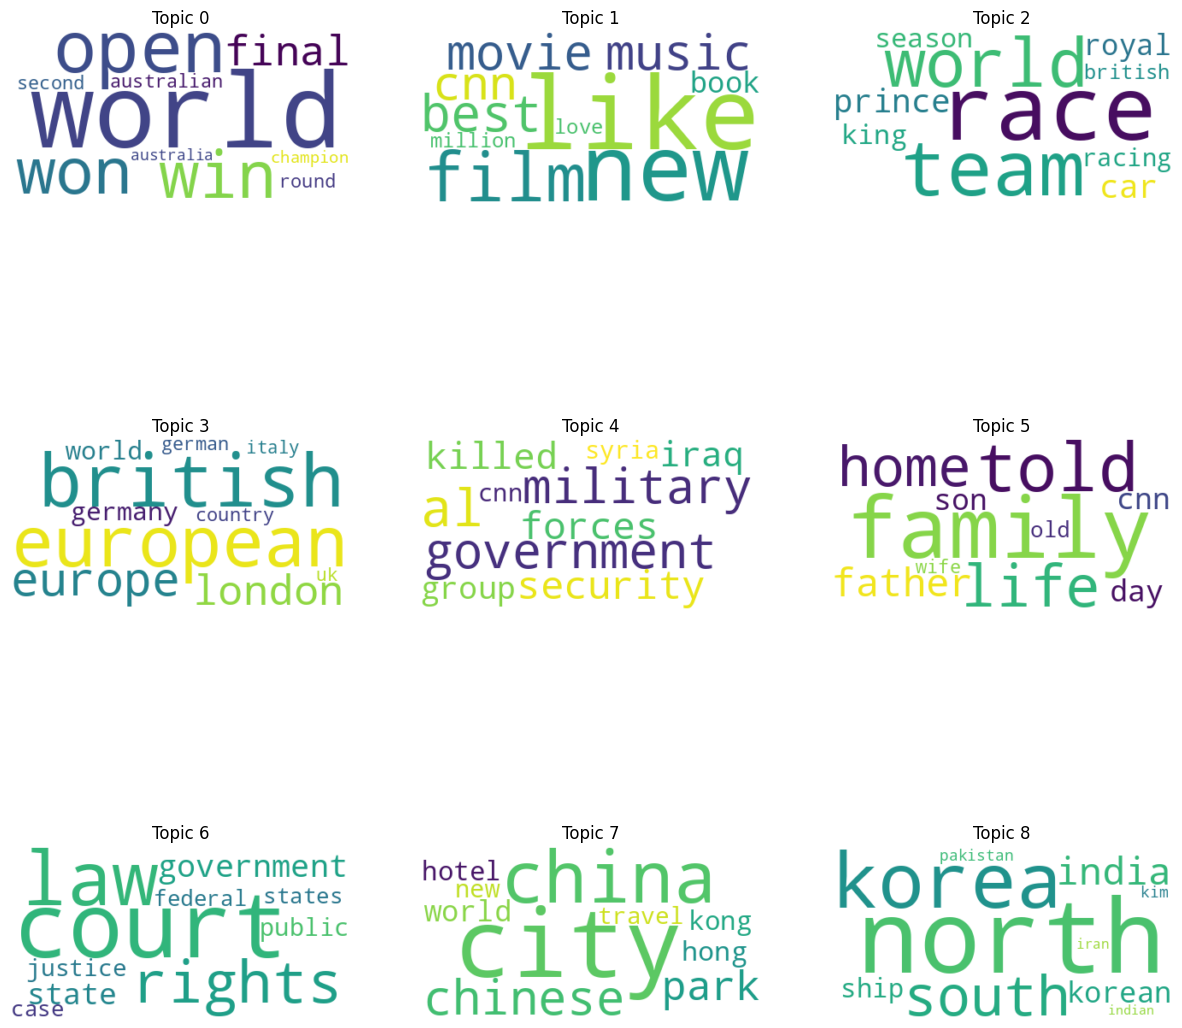

In [38]:
# Визуализация первых 9 тем
render_word_cloud(lda_model, 3, 3, 10)

## Поиск похожих документов

Gensim имеет модуль `similarities`, создающий *индекс* для каждого набора документов.

Здесь мы используем `MatrixSimilarity`, который подсчитывает косинусное сходство по всему корпусу и сохраняет их в индексы.

In [39]:
lda_index = similarities.MatrixSimilarity(
    lda_model[corpus_bow_w_pos_filtered], num_features=len(dictionary_w_pos)
)

Следующая функция позволяет извлечь *first_m_words* из *top_n* самых похожих документов.

In [40]:
def get_similar_articles(
    index, model, article_bow, top_n=5, first_m_words=300
):
    # model[article_bow] retrieves the topic distribution for the BOW.
    # index[model[article_bow] compares the topic distribution for the BOW against the similarity index previously computed.
    similar_docs = index[model[article_bow]]
    top_n_docs = sorted(enumerate(similar_docs), key=lambda item: -item[1])[
        1 : top_n + 1
    ]

    # Return a list of tuples with each tuple: (article id, similarity score, first_m_words of article)
    return list(
        map(
            lambda entry: (
                entry[0],
                entry[1],
                articles[entry[0]][:first_m_words],
            ),
            top_n_docs,
        )
    )

In [41]:
article_idx = 0
print(dataset[article_idx][:snippet_length], "\n")
get_similar_articles(
    lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx]
)

 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affa 



[(11523,
  0.9778771,
  "\n -- Bodies in the streets. Bloody faces pleading for help. Bandaged children in hospitals.\n\nThe horrific scenes and pleas coming out of Syria mount as activists claim President Bashar al-Assad's regime has been ratcheting up attacks, which the government denies.\n\nWhat's behind the increase in viole"),
 (17348,
  0.9760905,
  "\n -- Syria's civil war has been grinding on for nearly two years now, resulting in the deaths of more than 60,000 people, according to estimates from the office of the U.N. Human Rights Commissioner.\n\nMore than 500,000 Syrians have sought refuge in neighboring countries, and the U.N. believes that n"),
 (10064,
  0.9727926,
  '\n -- Somalia\'s Al-Shabaab has brushed aside accusations from Human Rights Watch that the Islamist militia recruits child soldiers, saying that Islam considers people to be adults from the age of 15.\n\n"The allegations from Human Rights Watch say that Al-Shabaab recruits young children at the age of 1'),
 

In [42]:
article_idx = 10
print(dataset[article_idx][:snippet_length], "\n")
get_similar_articles(
    lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx]
)


 -- The House Republican leadership upped the ante Thursday in the ongoing debate over the size and scope of the federal budget, unveiling a proposal to cut spending by $375 billion over the next five years.

House GOP Minority Whip Eric Cantor has been an outspoken critic of Democratic budget prop 



[(13549,
  0.9999838,
  '\n -- In a congressional version of hot potato, the Senate on Friday passed a short-term spending plan that would prevent a looming government shutdown and sent it to the House for a weekend showdown between Republican tea party conservatives and their more moderate party leaders.\n\nThe 54-44 vote on '),
 (18899,
  0.99990153,
  '\n -- Senate Democratic leaders met Thursday night with White House officials to consider including a government-funded public health insurance option, along with a provision allowing states to opt out of it, in a health care overhaul bill.\n\nSen. Olympia Snowe has been the only GOP supporter of healt'),
 (13301,
  0.99988604,
  '\n -- The federal government has shut down for the first time since 1996 and all eyes are focused on House Speaker John Boehner. Will he continue to insist upon tying a repeal or delay of Obamacare to a funding bill? Or will he bring the Senate-passed funding bill to the House floor and hope that he '),
 (62

In [43]:
article_idx = 100
print(dataset[article_idx][:snippet_length], "\n")
get_similar_articles(
    lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx]
)


 -- A tip led to Wednesday's arrest in Louisiana of a suspected serial bank robber dubbed the "Granddad Bandit," federal authorities said.

Michael Francis Mara, 52, was captured at his home in Baton Rouge, FBI Special Agent Sheila Thorne told CNN.

The FBI went to the residence to execute an arres 



[(16157,
  0.9771573,
  "\n -- In a dramatic reversal, the Florida state attorney's office announced Monday it will seek the death penalty against Casey Anthony, the 23-year-old woman charged in the death of her 2-year-old daughter Caylee.\n\nCasey Anthony is charged with first-degree murder in the slaying of her daughter Cayl"),
 (5770,
  0.97650003,
  '\n -- A 37-year-old Bronx woman accused of a charity scam after the Connecticut school mass shooting was indicted Tuesday on a charge of making false statements to the FBI, prosecutors said.\n\nThe federal indictment accuses Nouel Alba of Bronx, New York, of using "her Facebook account, telephone calls'),
 (11060,
  0.9762299,
  "\n -- The nude body of a former swimsuit model found last weekend in Orange County was identified through her breast implants' serial number, two law enforcement sources said Friday.\n\nAn arrest warrant has been issued for Ryan Alexander Jenkins, wanted in the death of Jasmine Fiore.\n\nAn arrest warran"),
 (

Мы также можем запросить похожие документы для новых, еще невиданных документов. 

In [44]:
test_article = "Capricorn Business Acquisitions Inc. (TSXV: CAK.H) (the “Company“) is pleased to announce that its board has approved the issuance of 70,000 stock options (“Stock Options“) to directors on April 19, 2020."

article_tokens = list(map(improved_filter, [nlp(test_article)]))[0]
article_bow = dictionary_w_pos.doc2bow(article_tokens)
get_similar_articles(lda_index, lda_model, article_bow)

[(11426,
  0.9973133,
  '\nThe critical Java vulnerability that is currently under attack was made possible by an incomplete patch Oracle developers issued last year to fix an earlier security bug, a researcher said.\n\nThe revelation, made Friday by Adam Gowdiak of Poland-based Security Explorations, is the latest black eye f'),
 (9747,
  0.99591196,
  '\n -- AOL has agreed to purchase The Huffington Post for $315 million, the two entities announced in a joint news release Monday.\n\n"As part of the transaction, Arianna Huffington, The Huffington Post\'s co-founder and editor-in-chief, will be named president and editor-in-chief of The Huffington Post '),
 (12706,
  0.99474496,
  "\n -- Apple's Internet-based messaging service, iMessage, has long had problems when it comes to interacting with non-Apple devices. Now the company is finally acknowledging the problems and rolling out a slate of bug fixes to make Apple-to-Android messaging less of a nightmare.\n\nInstead of sending r"),
 (

In [45]:
test_article = "DEA agent sentenced to 12 years in prison for conspiring with Colombian drug cartel."

article_tokens = list(map(improved_filter, [nlp(test_article)]))[0]
article_bow = dictionary_w_pos.doc2bow(article_tokens)
get_similar_articles(lda_index, lda_model, article_bow)

[(8051,
  0.9810548,
  '\n -- Philadelphia prosecutors plan to seek the death penalty against suspected serial strangler Antonio Rodriguez, according to District Attorney spokeswoman Tasha Jamerson.\n\nRodriguez appeared at a preliminary hearing Wednesday where two police detectives read confessions Rodriguez gave regarding t'),
 (5793,
  0.9809946,
  "\n -- Murder suspect Joran van der Sloot arrived Friday in Peru to face charges that he killed a Peruvian woman as police in Lima said they had identified the weapon that killed 21-year-old Stephany Flores Ramirez.\n\nFlores' body was found Wednesday in a Lima hotel room registered to van der Sloot, a "),
 (13925,
  0.9804552,
  '\n -- Authorities in Cleveland, Ohio, brought in cadaver dogs Wednesday to search the childhood home of a registered sex offender accused in the deaths of 11 women.\n\n"We\'re just trying to cover all our bases," said Scott Wilson, spokesman for the FBI, which is assisting local detectives in the case.\n'),
 (14